A place to keep all network analysis workflows in one notebook

In [1]:
from netCDF4 import Dataset
import mpl_toolkits.basemap as bmp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import datetime as dt
import colorcet as cc
import utilities as utils
import itertools
from scipy.stats import pearsonr
import sys
import time
import graph_tool.all as gt

/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/samserra/anaconda3/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error importing draw module, proceeding nevertheless: No module named 'cairo'
  warnings.warn(msg, RuntimeWarning)


In [14]:
fig_dir_name = '/home/samserra/Projects/ComplexNetworksAndClimateScience/Output/Images/'
fig_prefix = 'tsonisRecreation6-'

# Loading data

In [15]:
# load reanalysis data and variables
# Most recent NCAR Reanalysis File (as of 2020-02-29)
reanalysis = Dataset(
    '../Data/NCEP-NCAR Reanalysis (R1)/Monthly Surface Temperatures/air.mon.mean.nc', mode='r')
lons = reanalysis.variables['lon'][:]
lats = reanalysis.variables['lat'][:]
times = reanalysis.variables['time'][:]

In [16]:
# Load adjacency matricies of graphs
data = Dataset("../Output/tsonisRecreation6.nc", "r")
adj_elnino = data.groups['elNino'].variables['adjacency']
adj_lanina = data.groups['laNina'].variables['adjacency']

In [17]:
N = adj_elnino.shape[0] #number of nodes
indicies = [(lat_idx, lon_idx) for lat_idx in np.arange(1, len(lats)-1)
            for lon_idx in np.arange(len(lons))]

# Map of Area-Weighted Average Degree

In [6]:
# take off poles from lats list
lats_corr = lats[1:-1]
# get list of the cosines of the lattitude of each node
cos_lats = []
for latlon_idx in indicies:
    lat_idx, _ = latlon_idx
    cos_lats.append(lats[lat_idx])
# covert lats to radians
cos_lats = np.array(cos_lats)*np.pi/180
cos_lats = np.cos(cos_lats)
total_area = np.sum(cos_lats)
# find the area weighted connectivity for each node
connectivity_elnino = np.zeros(N)
connectivity_lanina = np.zeros(N)

connectivity_elnino = np.sum(adj_elnino[:, :]*cos_lats, axis=1)/total_area
connectivity_lanina = np.sum(adj_lanina[:, :]*cos_lats, axis=1)/total_area

# put connecectivity into shape lat-2 by lon
connectivity_elnino = connectivity_elnino.reshape(len(lats)-2, len(lons))
connectivity_lanina = connectivity_lanina.reshape(len(lats)-2, len(lons))

/home/samserra/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3172: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/samserra/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:3204: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


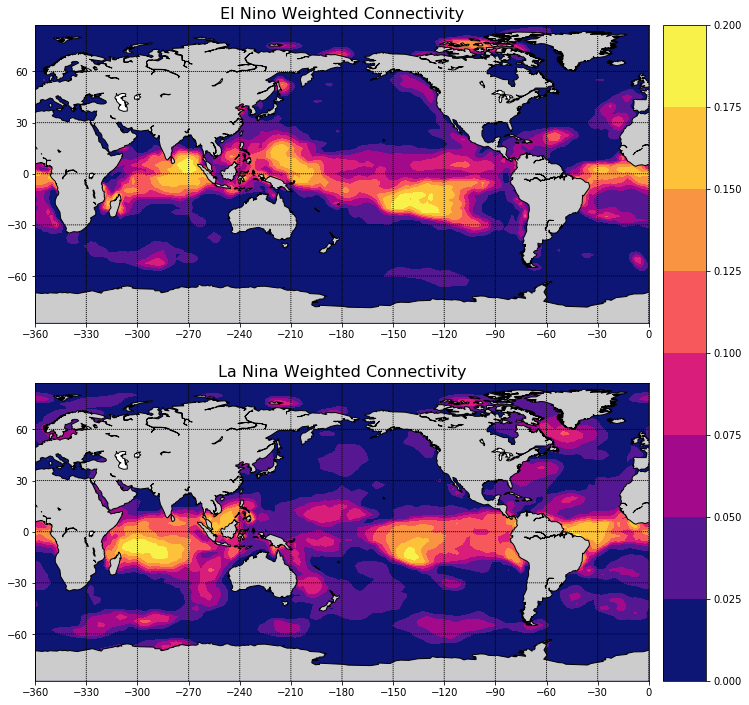

In [7]:
# find min/max connectivity between both plots
conmin = min(np.min(connectivity_elnino), np.min(connectivity_lanina))
conmax = max(np.max(connectivity_elnino), np.max(connectivity_lanina))
con_levels = np.linspace(conmin, conmax, 7)
# create normalized colorbar
norm = colors.Normalize(conmin, conmax)
# setup figure
fig, AX = plt.subplots(nrows=2, ncols=1)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_facecolor('white')
fig.tight_layout()

for idx in np.arange(2):
    # setup map projection
    m = bmp.Basemap(projection='cyl', resolution='c', lon_0=-180, lat_0=0,
                    llcrnrlon=-360, llcrnrlat=lats_corr[-1], urcrnrlon=0, urcrnrlat=lats_corr[0])
    m.drawcoastlines(ax=AX[idx])
    m.fillcontinents(ax=AX[idx])
    m.drawparallels(np.arange(-90, 90, 30), ax=AX[idx])
    m.drawmeridians(np.arange(0, 360, 30), ax=AX[idx])

# add 360 degree lon point so map is continuous
connectivity_elnino_cyc, lons_cyc = bmp.addcyclic(
    connectivity_elnino, lons)
connectivity_lanina_cyc, lons_cyc = bmp.addcyclic(
    connectivity_lanina, lons)
# Shift the grid so lons go from -180 to 180 instead of 0 to 360.
connectivity_elnino_cyc, lons_cyc = bmp.shiftgrid(
    0, connectivity_elnino_cyc, lons_cyc, start=False)
connectivity_lanina_cyc, lons_cyc = bmp.shiftgrid(
    0, connectivity_lanina_cyc, lons_cyc, start=False)

# because lats, lons not the same length, create grid
lons2d, lats2d = np.meshgrid(lons_cyc, lats_corr)
x, y = m(lons2d, lats2d)

# contour plots: top is el nino, bottom is la nina
cs = m.contourf(x, y, connectivity_elnino_cyc, latlon=False,
                ax=AX[0], cmap=cc.cm.linear_bmy_10_95_c71, norm=norm)
AX[0].set_title("El Nino Weighted Connectivity", fontsize=16)

cs = m.contourf(x, y, connectivity_lanina_cyc, latlon=False,
                ax=AX[1], cmap=cc.cm.linear_bmy_10_95_c71, norm=norm)
AX[1].set_title("La Nina Weighted Connectivity", fontsize=16)

# Colorbar
fig.subplots_adjust(right=.95, hspace=.2, top=.95)
# get location for top and bottom of colorbar
bottom = AX[1].get_position().ymin
top = AX[0].get_position().ymax
left = AX[1].get_position().xmax

cbar_ax = fig.add_axes([left+.01, bottom, .03, top-bottom])
cbar = fig.colorbar(cs, cax=cbar_ax, ticklocation='right')
#cbar.set_label("Fraction of Total Global Area Connected", fontsize=16)

# axis ticks
for ax in AX:
    ax.set_xticks(np.arange(-360, 1, 30))
    ax.set_yticks(np.arange(-90, 90, 30)[1:])
# savefig
fig.savefig(fig_dir_name + fig_prefix + 'weightedConnectivity.jpg')

# Adjacency Matrix Images

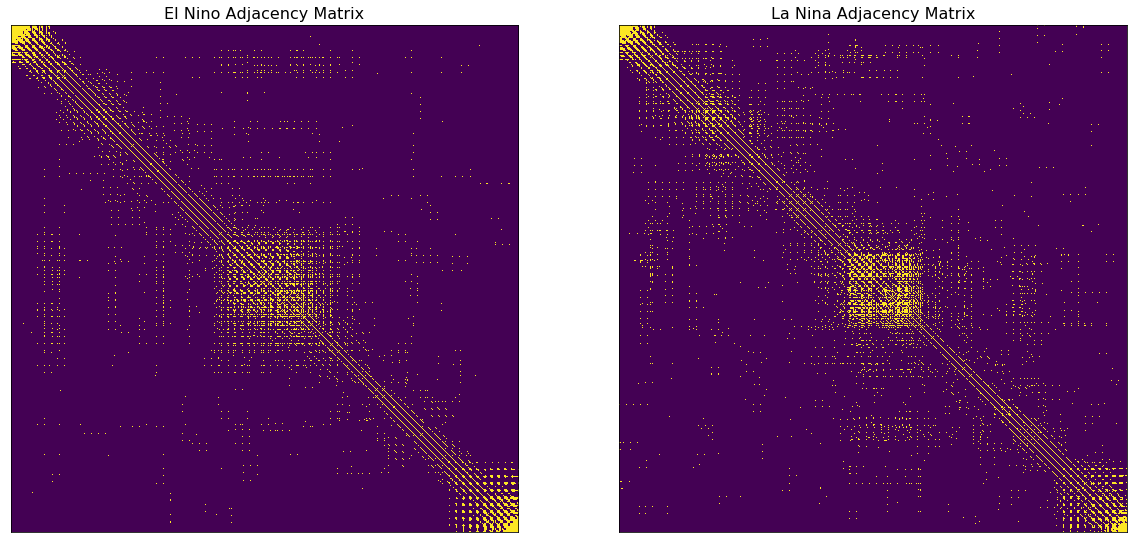

In [8]:
fig, AX = plt.subplots(1,2,sharey=True,sharex=True)
fig.set_figwidth(20)
fig.set_figheight(10)
fig.set_facecolor("white")

AX[0].imshow(adj_elnino[:,:])
AX[1].imshow(adj_lanina[:,:])

AX[0].set_title("El Nino Adjacency Matrix",fontsize=16)
AX[1].set_title("La Nina Adjacency Matrix",fontsize=16)
AX[0].set_xticks([])
AX[0].set_yticks([])

# savefig
fig.savefig(fig_dir_name + fig_prefix +'adjMatricies.jpg')

# Degree Distributions

Node Degree PDF (a really bad graph)

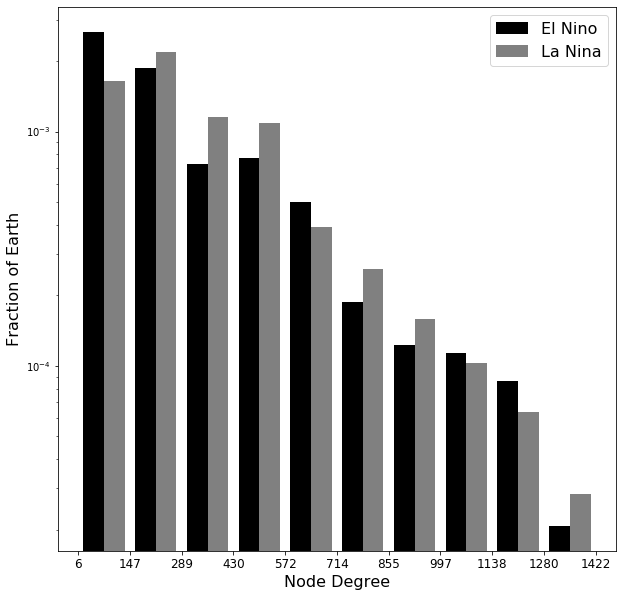

In [9]:
degs_elnino = np.sum(adj_elnino[:,:],0)
degs_lanina = np.sum(adj_lanina[:,:],0)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('white')

hist = ax.hist([degs_elnino, degs_lanina], bins=10, \
            label=["El Nino", "La Nina"],density=True,log=True, stacked=False, color=['black','gray'])
ax.set_xlabel('Node Degree',fontsize=16)
ax.set_ylabel('Fraction of Earth',fontsize=16)
ax.legend(fontsize=16)

#fix x axis
bins = hist[1]
ax.set_xticks(bins)
ax.set_xticklabels(bins.astype('int'), fontsize=12)

#fix y axis
ylabs = ax.get_yticklabels()
#TODO?

# savefig
fig.savefig(fig_dir_name + fig_prefix +'degreeDistPDFs.jpg')

Node Degree CDF

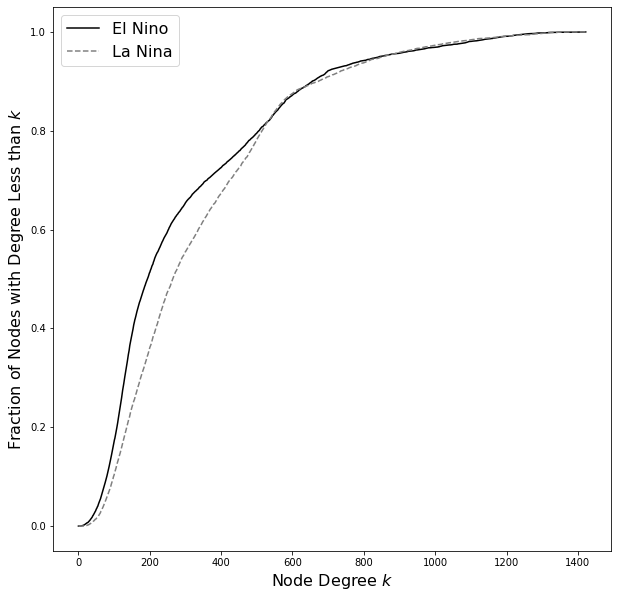

In [10]:
# create list of all possible node degrees
max_deg = max(np.max(degs_elnino),np.max(degs_lanina))
xdata = np.arange(0,max_deg+1,1)

# find how many nodes have each degree or lower
cdf_elnino = np.zeros(len(xdata))
cdf_lanina = np.zeros(len(xdata))
for deg in xdata:
    cdf_elnino[deg] = np.sum(degs_elnino<=deg)
    cdf_lanina[deg] = np.sum(degs_lanina<=deg)
# and normalize to make it a cdf
cdf_elnino /= N
cdf_lanina /= N

#---------
# Plot
fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('white')

ax.plot(xdata,cdf_elnino, label='El Nino',ls='-',color='black')
ax.plot(xdata,cdf_lanina, label='La Nina',ls='--',color='gray')
ax.legend(fontsize=16)

ax.set_xlabel('Node Degree $k$',fontsize=16)
ax.set_ylabel('Fraction of Nodes with Degree Less than $k$',fontsize=16)

# savefig
fig.savefig(fig_dir_name + fig_prefix +'degreeDistCDFs.jpg')

# Charecteristic Path Length and Clustering Coefficient (with graph-tools)

In [11]:
adj_matricies = [adj_elnino[:,:], adj_lanina[:,:]]
names = ['El Nino', 'La Nina']

elnino_graph, lanina_graph = gt.Graph(), gt.Graph()
graphs = [elnino_graph, lanina_graph]

clustering_coefs, char_paths = [], []
for gdx in np.arange(2):
    graphs[gdx].add_vertex(N)
    
    idx, idy = adj_matricies[gdx].nonzero() # get support of adj matrix
    supp_indicies = np.dstack((idx,idy))
    supp_indicies.resize((N,2)) # dstack returns array of shape (1,N,2), but we need shape (N,2)
    graphs[gdx].add_edge_list(supp_indicies) # add edges to graph
    
    # calculate clustering coefficients
    clustering_coef = gt.global_clustering(graphs[gdx])
    clustering_coefs.append(clustering_coef)
    
    # to calculate char path length, note the graph may not be connected
    # so we calculate average over all connected components 
    dists = gt.shortest_distance(graphs[gdx]) # get geodesics as PropertyMap
    dists = dists.get_2d_array(np.arange(N)) # convert PropertyMap to matrix
    dists_corrected = np.where(dists==2147483647, 0, dists) # where the geodesic distance is the max int 2147483647, set the dist to zero
    num_pairs = np.sum(dists_corrected != 0) 
    char_path_len = np.sum(dists_corrected)/num_pairs # extended def of char path length: divide by number of non-zero pairs
    char_paths.append((char_path_len, num_pairs))

    print('{:s}'.format(names[gdx]))
    print('-'*10)
    print('Clustering Coefficient: {:.3f}'.format(clustering_coef[0]))
    print('Char Path Length: {:.3f} with {:n} pairs of verticies having positive, finite distance \n'.format(char_path_len, num_pairs))
    
with open(fig_dir_name+'NetworkCharecteristics.txt', 'a') as f:
    f.write('='*20 + '\n')
    f.write(fig_prefix[:-1]+'\n')
    for idx in range(2):
        f.write('{:s}\n'.format(names[idx]))
        f.write('-'*10 + '\n')
        f.write('Clustering Coefficient: {:.3f}\n'.format(clustering_coefs[idx][0]))
        f.write('Char Path Length: {:.3f} with {:n} pairs of verticies having positive, finite distance \n'.format(char_paths[idx][0],char_paths[idx][1]))
        f.write('\n')

El Nino
----------
Clustering Coefficient: 0.155
Char Path Length: 1.064 with 10900 pairs of verticies having positive, finite distance 

La Nina
----------
Clustering Coefficient: 0.188
Char Path Length: 1.154 with 12052 pairs of verticies having positive, finite distance 



# Onion Decomp and Spectrum

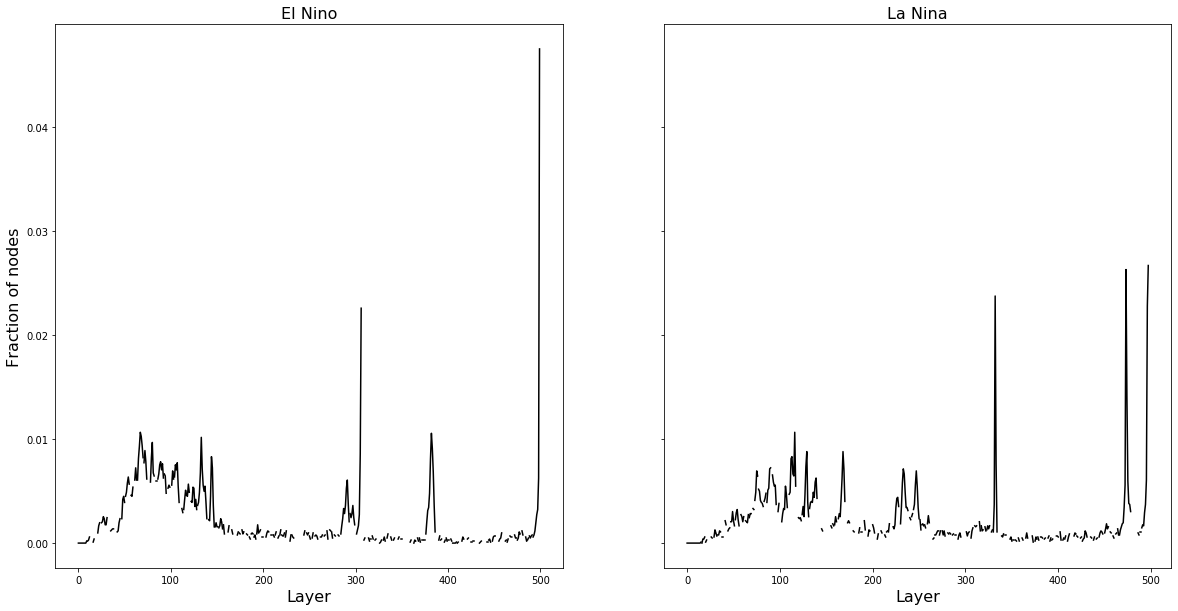

In [18]:
adj_matricies = [adj_elnino[:,:], adj_lanina[:,:]]
names = ['El Nino', 'La Nina']

fig, ax = plt.subplots(ncols=2, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.set_facecolor('white')

for idx in [0, 1]:
    cores, layers = utils.onion_decomp(adj_matricies[idx])
    total_layers, frac_in_layer = utils.onion_spectrum(layers)

    previous_max = 0
    for core in np.unique(cores):
        max_layer_in_core = max(layers[cores == core]).astype('int')
        ax[idx].plot(total_layers[previous_max:max_layer_in_core+1],
                     frac_in_layer[previous_max:max_layer_in_core+1], label=core, color='black')
        previous_max = max_layer_in_core+1
    # ax[idx].legend(title='Cores')
    ax[idx].set_title(names[idx], fontsize=16)
    ax[idx].set_xlabel('Layer', fontsize=16)
ax[0].set_ylabel('Fraction of nodes', fontsize=16)

# savefig
fig.savefig(fig_dir_name + fig_prefix + 'ODEs.jpg')